In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc


In [99]:
df = pd.read_csv('/content/bikeshare.csv')

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   notbizday   17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   hum         17379 non-null  float64
 10  windspeed   17379 non-null  float64
 11  dteday      17379 non-null  object 
 12  cnt         17379 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 1.7+ MB


In [101]:
#1

#define the target variable 'overload'
df['overload'] = np.where(df['cnt'] > 500, 1, 0)

# Calculate the proportions of overload vs. non-overload
overload_proportion = df['overload'].value_counts(normalize=True)

print(overload_proportion)

overload
0    0.926405
1    0.073595
Name: proportion, dtype: float64


In [102]:

df = df.drop(['dteday'], axis=1)


The target variable is heavily imbalanced.

In [103]:
#2

#define features
X = df.drop('overload', axis=1)
y = df['overload']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [104]:
#3.1

# Initialize and train the KNN classifier with default parameters
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [105]:

#make predictions on the test set
y_pred = knn.predict(X_test)



In [106]:
#3.2

#Make predictions on the test set
y_hat_probs = knn.predict_proba(X_test)
y_hat = knn.predict(X_test)


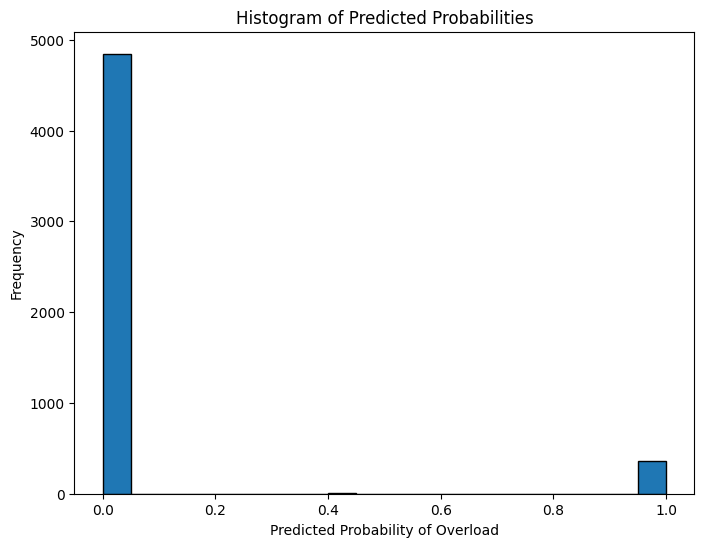

In [107]:
#3.3

#Extract probabilities for the positive class (class 1)
positive_probs = y_hat_probs[:, 1]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(positive_probs, bins=20, edgecolor='black')
plt.xlabel('Predicted Probability of Overload')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()


#cHeck for thresholds
#find the probability threshold at which the model always predicts negative or positive
threshold_positive = 0
threshold_negative = 0
for i, prob in enumerate(positive_probs):
    if y_hat[i] == 1 and prob > threshold_positive:
        threshold_positive = prob
    if y_hat[i] == 0 and prob < threshold_negative:
        threshold_negative = prob



The model always predicts the positive class at a value of 1 and the negative class at a vlaue of 0.

In [108]:
#3.4

# Create predictions for the 30% threshold
y_hat_30 = (positive_probs >= 0.3).astype(int)

# Create predictions for the 70% threshold
y_hat_70 = (positive_probs >= 0.7).astype(int)



A lower threshold would yield more positive cases and thus less cases assigned to the negative class when they are actually positive. So in this cas elowering the threshold would help minimize the amount of false negatives.

In [109]:
#3.5

df_predictions = pd.DataFrame({'y_test': y_test,
                             'y_hat_default': y_hat,
                             'y_hat_30': y_hat_30,
                             'y_hat_70': y_hat_70,
                             'y_hat_probs': positive_probs})

In [110]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef



def my_KNN_report(X_train, y_train, X_test,y_test, K=5, threshold=0.5, weights='uniform'):
    knn= KNeighborsClassifier(n_neighbors=K, weights=weights)
    knn.fit(X_train, y_train)
    probs = knn.predict_proba(X_test)[:,1]
    y_hat = np.where(probs>=threshold,1,0)

    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test,y_hat) ,4)
    error_rate = round(1-accuracy,4)
    precision = round(precision_score(y_test,y_hat),2)
    recall = round(recall_score(y_test,y_hat),2)
    f1score = round(f1_score(y_test,y_hat),2)
    MCC = round(matthews_corrcoef(y_test,y_hat),2)
    cm_labled = pd.DataFrame(cm, index=['Actual : negative ','Actual : positive'], columns=['Predict : negative','Predict :positive '])

    print("-----------------------------------------")
    print('Accuracy  = {}'.format(accuracy))
    print('Error_rate  = {}'.format(error_rate))
    print('Precision = {}'.format(precision))
    print('Recall    = {}'.format(recall))
    print('f1_score  = {}'.format(f1score))
    print('MCC       = {}'.format(MCC))
    print("-----------------------------------------")
    return cm_labled



In [111]:
my_KNN_report(X_train, y_train, X_test,y_test, K=10, threshold=0.5, weights='uniform')

-----------------------------------------
Accuracy  = 0.9996
Error_rate  = 0.0004
Precision = 1.0
Recall    = 0.99
f1_score  = 1.0
MCC       = 1.0
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,4850,0
Actual : positive,2,362


No, I cannot trust the accuracy of the model because accuracy doesn't account for the hevay imbalance of the data, the model clearly predicts the negative classa majority of the team a, which results in a higher accuracy, but that doesn't tell how it performs on the other class in case that is of more concern.

In [112]:
my_KNN_report(X_train, y_train, X_test,y_test, K=10, threshold=0.3, weights='uniform')

-----------------------------------------
Accuracy  = 0.9996
Error_rate  = 0.0004
Precision = 0.99
Recall    = 1.0
f1_score  = 1.0
MCC       = 1.0
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,4848,2
Actual : positive,0,364


The results do not make sense, the performance metrics are most likely incorrect. F1, Accuracy, Recall are near 1 meaning the model performed perferctely which just isn't likely.

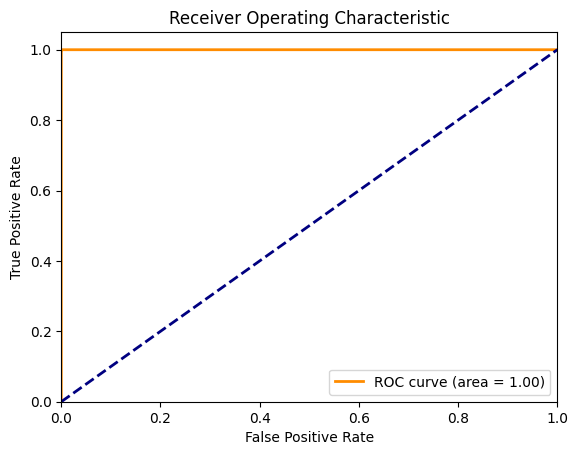

AUC score: 0.9999983006684038


In [113]:
#5

fpr, tpr, thresholds = roc_curve(y_test, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC score: {roc_auc}")


The model is doing better than random chance.

In [114]:
#6.1

from sklearn.model_selection import KFold

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

error_rates_cv = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    knn = KNeighborsClassifier()
    knn.fit(X_train_fold, y_train_fold)
    y_pred_fold = knn.predict(X_val_fold)

    error_rate_fold = 1 - accuracy_score(y_val_fold, y_pred_fold)
    error_rates_cv.append(error_rate_fold)

error_rate_CV = np.mean(error_rates_cv)
print(f"Error rate CV: {error_rate_CV}")

Error rate CV: 0.000657624332100304


In [ ]:
# 6.2

k_values = range(1, 31)
error_rates = []

for k in k_values:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    error_rates_cv = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_fold, y_train_fold)
        y_pred_fold = knn.predict(X_val_fold)

        error_rate_fold = 1 - accuracy_score(y_val_fold, y_pred_fold)
        error_rates_cv.append(error_rate_fold)
    error_rates.append(np.mean(error_rates_cv))

# Find the optimal k
optimal_k = k_values[np.argmin(error_rates)]
print(f"Optimal k: {optimal_k}")

# Plot error rate vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, error_rates, marker='o')
plt.title('Error Rate vs. k')
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.xticks(k_values)  # Ensure all k values are displayed on x-axis
plt.grid(True)
plt.show()

##7

The price of a single idle bike is less than the cost of a single unexpected overload. We want to minimize the amount of idel bike costs and unexpected overloads. A threshold of 0.3 would predict more overload bikes which would lead to less idle bikes, FN, but it increase the chance of a unexpected overload when it is not, FP. But since the cost of predicitng unexpected overload is higher we would want this result. The threshold of 0.5, 0.7 would led to less predicted unexpected overloads which woiuld lead to higher costs.